In [78]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading

In [79]:
video_df = pd.read_csv("videos-stats.csv")
comm_df = pd.read_csv("comments.csv")

# Drop Unnamed: 0 column
video_df = video_df.drop(columns=["Unnamed: 0"])
comm_df = comm_df.drop(columns=["Unnamed: 0"])

# Drop nan values
video_df = video_df.dropna()
comm_df = comm_df.dropna()

# Drop duplicates
video_df.drop_duplicates(keep='first', inplace=True)
comm_df.drop_duplicates(keep='first', inplace=True)

# Cast columns to int
video_df["Likes"] = video_df["Likes"].astype(int)
video_df["Comments"] = video_df["Comments"].astype(int)
video_df["Views"] = video_df["Views"].astype(int)
comm_df["Likes"] = comm_df["Likes"].astype(int)
comm_df["Sentiment"] = comm_df["Sentiment"].astype(int)


# Text Cleaning

In [80]:
!pip install emoji
import re
import emoji
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_text(text):

    # Remove emojis
    text = emoji.demojize(text).replace('_', ' ')

    # Remove \r and \n
    text = text.replace('\r', '').replace('\n', ' ')

    # Remove links and mentions
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)

    # Remove :
    text = text.replace(':', ' ')

    # Remove punctuations
    punc = string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    translations = str.maketrans('', '', punc)
    text = text.translate(translations)

    # Remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text)

    # Remove hashtags
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text))
    text = " ".join(word.strip() for word in re.split('#|_', text))

    # Remove $ and &
    text.replace('$', '').replace('&', '')

    # Remove multiple spaces
    text = re.sub("\s\s+" , " ", text)

    #####################################

    # Tokenize the text
    #tokens = word_tokenize(text)

    # Convert to lowercase and remove non-alphabetic tokens
    #tokens = [t.lower() for t in tokens if t.isalpha()]

    # Remove stop words and lemmatize
    #stop_words = stopwords.words('english')
    #lemma = WordNetLemmatizer()
    #tokens = [lemma.lemmatize(t) for t in tokens if t not in stop_words]
    #tokens = [t for t in tokens if t not in stop_words]

    #return ' '.join(tokens)
    return text

def preprocess_df(df, max_seq_len=None):
    # Clean the comments
    df['new_comment'] = df['Comment'].apply(clean_text)

    # Add comment lengths
    df['comment_len'] = df['new_comment'].apply(lambda x: len(str(x).split()))

    # Removing empty comments
    new_df = df[df['comment_len'] > 0]

    # Remove outliers
    if max_seq_len is not None:
        new_df = new_df[new_df['comment_len'] <= max_seq_len]

    return new_df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [81]:
max_seq_len = 50
new_comm_df = preprocess_df(comm_df, max_seq_len)

# Train Test Validation Splitting

In [82]:
X = new_comm_df['new_comment'].to_numpy()
y = new_comm_df['Sentiment'].to_numpy()

In [83]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

# Oversampling on Train Set

In [84]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train.reshape(-1, 1), y_train.reshape(-1, 1))

# One-hot Encoding Sentiments

In [85]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = one_hot_encoder.transform(np.array(y_test).reshape(-1, 1))
y_val = one_hot_encoder.transform(np.array(y_val).reshape(-1, 1))

# NN Model Development With USE Embedding Layer

In [40]:
import tensorflow as tf
import tensorflow_hub as hub
tf.random.set_seed(42)

use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           input_shape=[], # Variable sized input
                           dtype=tf.string,
                           trainable=False, # Keep the pretrained weights
                           name="USE_layer")

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

model = tf.keras.Sequential([use_layer,
                             layers.Dense(512, activation="relu", name="dense_1"),
                             layers.Dense(3, activation="softmax", name="output_layer")
                             ], name="nn_use")

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

model.summary()

Model: "nn_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 257062019 (980.61 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [42]:
history_3 = model.fit(X_train,
                    y_train,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/30
690/690 [==============================] - 28s 35ms/step - loss: 0.5793 - accuracy: 0.7626 - val_loss: 0.5406 - val_accuracy: 0.7780
Epoch 2/30
690/690 [==============================] - 15s 21ms/step - loss: 0.4224 - accuracy: 0.8395 - val_loss: 0.5223 - val_accuracy: 0.7764
Epoch 3/30
690/690 [==============================] - 10s 14ms/step - loss: 0.2962 - accuracy: 0.9022 - val_loss: 0.5341 - val_accuracy: 0.7866
Epoch 4/30
690/690 [==============================] - 9s 13ms/step - loss: 0.2029 - accuracy: 0.9380 - val_loss: 0.5579 - val_accuracy: 0.7834
Epoch 5/30
690/690 [==============================] - 10s 15ms/step - loss: 0.1382 - accuracy: 0.9613 - val_loss: 0.5675 - val_accuracy: 0.7912
Epoch 6/30
690/690 [==============================] - 9s 13ms/step - loss: 0.0955 - accuracy: 0.9776 - val_loss: 0.5937 - val_accuracy: 0.8045
Epoch 7/30
690/690 [==============================] - 10s 15ms/step - loss: 0.0642 - accuracy: 0.9865 - val_loss: 0.6311 - val_accuracy: 0

In [94]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def plot_conf_matrix(y_test, y_pred):
    y_pred_arg = np.argmax(y_pred, axis=1)
    y_test_arg = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test_arg, y_pred_arg)
    cmdisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
    cmdisp.plot()
    plt.show()

def calculate_acc(y_test, y_pred):
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    print('Accuracy:', accuracy)

def plot_loss_acc(history):

    # Plot train-validation losses
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    epochs = range(1, len(history.history['loss']) + 1)
    ax[0].plot(epochs, history.history['loss'], marker='o', label='Train Loss')
    ax[0].plot(epochs, history.history['val_loss'], marker='o', label='Validation Loss')
    ax[0].set_title('Train and Validation Losses Over Epochs')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)
    ax[0].legend(loc='upper right')

    # Plot train-validation accuracies
    ax[1].plot(epochs, history.history['accuracy'], marker='o', label='Train Accuracy')
    ax[1].plot(epochs, history.history['val_accuracy'], marker='o', label='Validation Accuracy')
    ax[1].set_title('Train and Validation Accuracies Over Epochs')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)
    ax[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

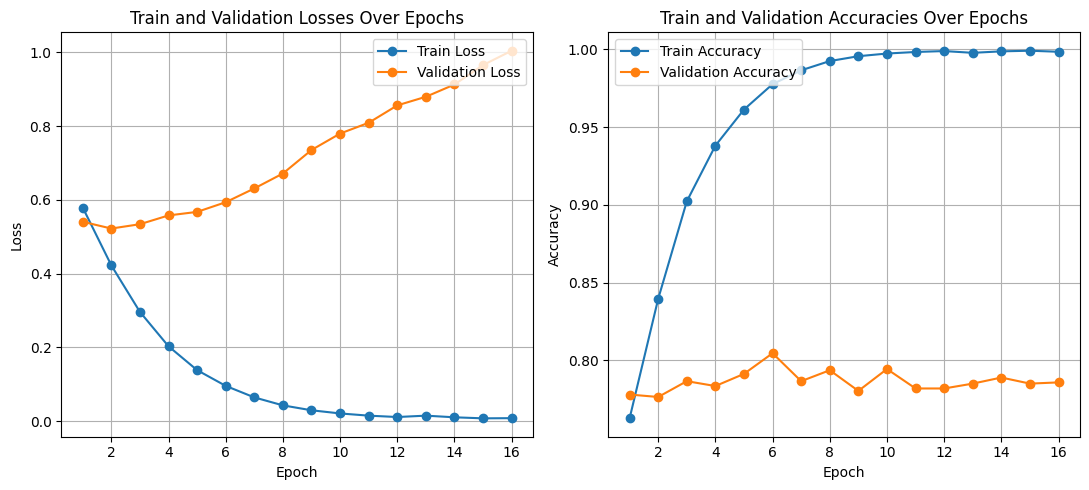

In [44]:
plot_loss_acc(history_3)

In [101]:
y_pred = model.predict(X_test)
calculate_acc(y_test, y_pred)

71/71 [==============================] - 1s 18ms/step
Accuracy: 0.8131089459698848


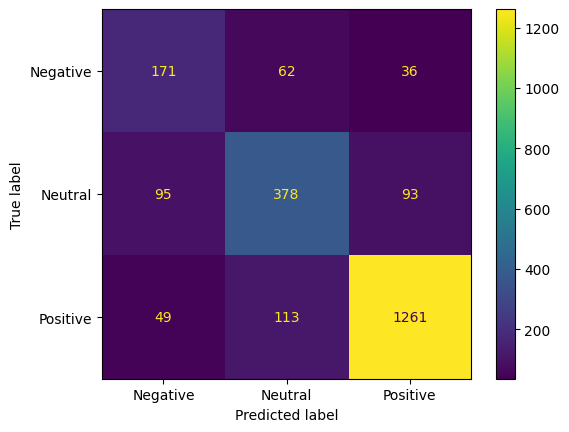

In [95]:
plot_conf_matrix(y_test, y_pred)

In [102]:

from sklearn.metrics import classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.59      0.62      0.61       269
           1       0.75      0.62      0.68       566
           2       0.88      0.92      0.90      1423

    accuracy                           0.81      2258
   macro avg       0.74      0.72      0.73      2258
weighted avg       0.81      0.81      0.81      2258



# LSTM Model Development With USE Embedding Layer

In [72]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

# Model with LSTM
model_lstm = tf.keras.Sequential([use_layer,
                                  tf.keras.layers.Reshape((1, 512), name='reshape_layer'),
                                  layers.Bidirectional(layers.LSTM(units=128, return_sequences=True), name='bidirectional_lstm_1'),
                                  layers.Bidirectional(layers.LSTM(units=64), name='bidirectional_lstm_2'),
                                  #layers.LSTM(units=100, return_sequences=True, name='lstm_1'),
                                  #layers.LSTM(units=50, name='lstm_2'),
                                  layers.Dense(3, activation="softmax", name='output_layer')
                                  ], name="lstm_use")

model_lstm.compile(loss="categorical_crossentropy",
                   optimizer=tf.keras.optimizers.Adam(),
                   metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

model_lstm.summary()

Model: "lstm_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 reshape_layer (Reshape)     (None, 1, 512)            0         
                                                                 
 bidirectional_lstm_1 (Bidi  (None, 1, 256)            656384    
 rectional)                                                      
                                                                 
 bidirectional_lstm_2 (Bidi  (None, 128)               164352    
 rectional)                                                      
                                                                 
 output_layer (Dense)        (None, 3)                 387       
                                                                 
Total params: 257618947 (982.74 MB)
Trainable params: 8211

In [73]:
history_4 = model_lstm.fit(X_train,
                           y_train,
                           epochs=30,
                           validation_data=(X_val, y_val),
                           callbacks=[early_stopping])

Epoch 1/30
690/690 [==============================] - 26s 26ms/step - loss: 0.6100 - accuracy: 0.7470 - val_loss: 0.5682 - val_accuracy: 0.7639
Epoch 2/30
690/690 [==============================] - 16s 22ms/step - loss: 0.5186 - accuracy: 0.7848 - val_loss: 0.5511 - val_accuracy: 0.7686
Epoch 3/30
690/690 [==============================] - 14s 21ms/step - loss: 0.4706 - accuracy: 0.8072 - val_loss: 0.5511 - val_accuracy: 0.7772
Epoch 4/30
690/690 [==============================] - 13s 19ms/step - loss: 0.3943 - accuracy: 0.8441 - val_loss: 0.6068 - val_accuracy: 0.7639
Epoch 5/30
690/690 [==============================] - 15s 21ms/step - loss: 0.3056 - accuracy: 0.8845 - val_loss: 0.6214 - val_accuracy: 0.7717
Epoch 6/30
690/690 [==============================] - 14s 20ms/step - loss: 0.2322 - accuracy: 0.9142 - val_loss: 0.6372 - val_accuracy: 0.7866
Epoch 7/30
690/690 [==============================] - 13s 19ms/step - loss: 0.1739 - accuracy: 0.9368 - val_loss: 0.7582 - val_accuracy:

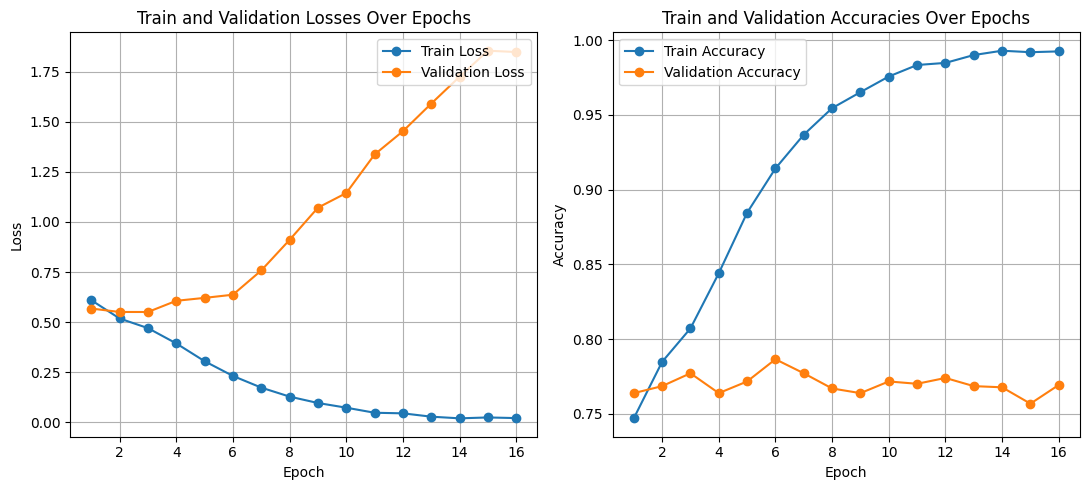

In [74]:
plot_loss_acc(history_4)

In [90]:
y_pred = model_lstm.predict(X_test)
calculate_acc(y_test, y_pred)

71/71 [==============================] - 2s 28ms/step
Accuracy: 0.8015943312666076


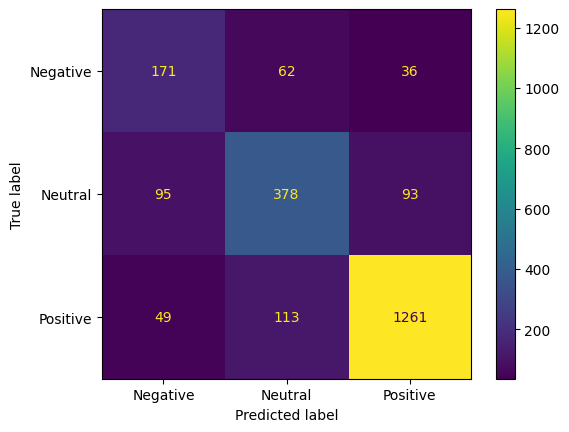

In [91]:
plot_conf_matrix(y_test, y_pred)

In [99]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.54      0.64      0.59       269
           1       0.68      0.67      0.68       566
           2       0.91      0.89      0.90      1423

    accuracy                           0.80      2258
   macro avg       0.71      0.73      0.72      2258
weighted avg       0.81      0.80      0.80      2258



## Analysis of Results:

### **Accuracy**:

Both models have similar overall accuracy *(First model: **0.81**, Second model: **0.80**)*, indicating that both perform well in general sentiment prediction.

### **Class-wise Performance**:

**Class 0** ***(Negative sentiment)***:
The first model has slightly better precision *(0.59 vs. 0.54)* but slightly lower recall *(0.62 vs. 0.64)*.
Both models have comparable F1-scores *(0.61 vs. 0.59)*.

**Class 1** ***(Neutral sentiment)***:
The first model has better precision *(0.75 vs. 0.68)* and slightly better recall *(0.62 vs. 0.67)*.
F1-scores are identical *(0.68 vs. 0.68)*.

**Class 2** ***(Positive sentiment)***:
Both models perform exceptionally well with high precision *(0.88 vs. 0.91)* and recall *(0.92 vs. 0.89)*.
F1-scores are very close *(0.90 vs. 0.90)*.

**Macro and Weighted Averages**:

The first model has slightly better macro and weighted averages for precision, recall, and F1-score.



### **Conclusion**:

**Overall Performance**:

Both models perform well, with the first model having a slight edge in overall accuracy and macro averages. The differences are marginal, suggesting that either model could be viable depending on the specific application requirements.

**Model Selection**:

If precision for neutral sentiment (class 1) is more critical, the first model might be preferable.
In this task, handling sequences and context in comments is more important, the second model with LSTM layers might be beneficial despite slightly lower overall performance metrics, as LSTMs can capture sequential dependencies better than dense layers.